In [ ]:
# default_exp modules.data

In [ ]:
#export
import numpy as np
import glob
import os
import uproot as ur
import time
from multiprocessing import Process, Queue, set_start_method
import compress_pickle as pickle
from scipy.stats import circmean
import random
import itertools
import tensorflow as tf

import matplotlib.pyplot as plt # optional
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

import pandas as pd

In [ ]:
pd.set_option('display.max_columns', None)

# GraphDataGenerator

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
file = "../../data/onetrack_multicluster/pion_files/001.npy"
event_data = np.load(file, allow_pickle=True).item()

In [ ]:
np.array(pd.DataFrame(event_data).trackEta.explode())

array([-0.046390757, 0.2506888, -1.9193794, ..., -2.137757, 1.7711043,
       0.061526895], dtype=object)

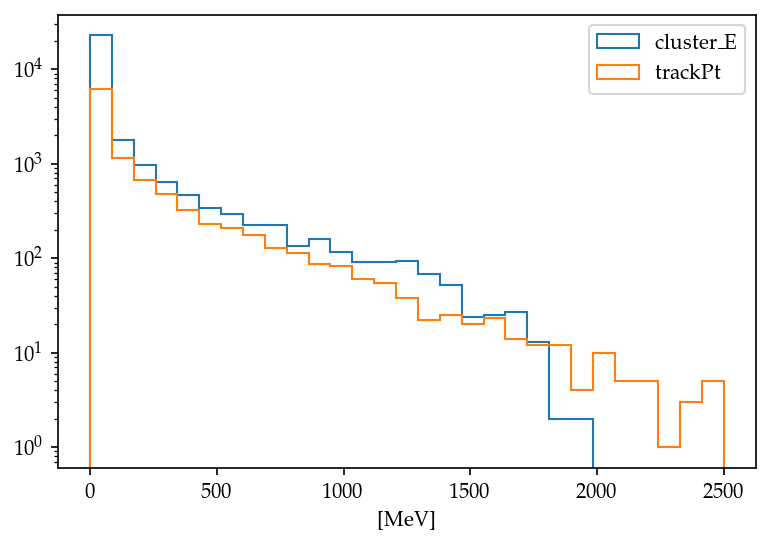

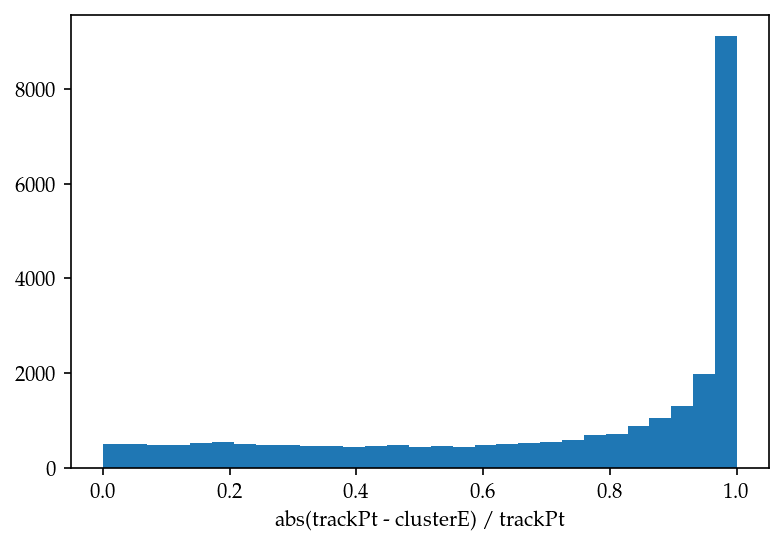

In [ ]:
plt.figure(dpi=150)
bins = np.linspace(0,2500,30)
# plt.hist(np.concatenate(event_data['truthPartE']).ravel(), color='black', bins=bins, histtype='step', label="truthPartE");
plt.hist(np.concatenate(event_data['cluster_E']).ravel(), bins=bins, histtype='step', label="cluster_E");
plt.hist(np.array(event_data['trackPt']), bins=bins, histtype='step', label='trackPt');
plt.legend();
plt.yscale('log');
plt.xlabel('[MeV]');

deltas = []
for i in range(len(event_data['cluster_E'])):
    for j in range(event_data['nCluster'][i]):
        deltas.append(np.abs(event_data['trackPt'][i]-event_data['cluster_E'][i][j])/event_data['trackPt'][i])
        
plt.figure(dpi=150)
plt.hist(np.concatenate(deltas), bins=np.linspace(0,1, 30));
plt.xlabel("abs(trackPt - clusterE) / trackPt");

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
#export

scales = {
     'track_pt_mean': 1.633278727,
     'track_pt_std': 0.8481947183,
     'track_z0_mean': 0.08022017,
     'track_z0_std': 42.53320004,
     'track_eta_mean': -0.00563187,
     'track_eta_std': 1.35242735,
     'track_phi_mean': 0.00206431,
     'track_phi_std': 1.81240248,
     'truth_part_e_mean': 1.92469358,
     'truth_part_e_std': 0.8289864,
     'cluster_cell_e_mean': -1.0121697,
     'cluster_cell_e_std': 0.818357,
     'cluster_e_mean': 0.89923394,
     'cluster_e_std': 1.0585934,
     'cluster_eta_mean': 0.016195267,
     'cluster_eta_std': 1.3400925,
     'cluster_phi_mean': 0.0050816955,
     'cluster_phi_std': 1.8100655,
     'cell_geo_sampling_mean': 3.8827391420197177,
     'cell_geo_sampling_std': 3.9588233603576204,
     'cell_geo_eta_mean': 0.0005979097,
     'cell_geo_eta_std': 1.4709069,
     'cell_geo_phi_mean': -2.8938382e-05,
     'cell_geo_phi_std': 1.813651,
     'cell_geo_rPerp_mean': 1478.9285,
     'cell_geo_rPerp_std': 434.60815,
     'cell_geo_deta_mean': 0.026611786,
     'cell_geo_deta_std': 0.03396141,
     'cell_geo_dphi_mean': 0.068693615,
     'cell_geo_dphi_std': 0.038586758}

node_means = [
    scales["cluster_cell_e_mean"], 
    scales["cell_geo_sampling_mean"],
    scales["cell_geo_eta_mean"],
    scales["cell_geo_phi_mean"],
    scales["cell_geo_rPerp_mean"],
    scales["cell_geo_deta_mean"],
    scales["cell_geo_dphi_mean"],
] 

node_stds = [
    scales["cluster_cell_e_std"], 
    scales["cell_geo_sampling_std"],
    scales["cell_geo_eta_std"],
    scales["cell_geo_phi_std"],
    scales["cell_geo_rPerp_std"],
    scales["cell_geo_deta_std"],
    scales["cell_geo_dphi_std"],
] 

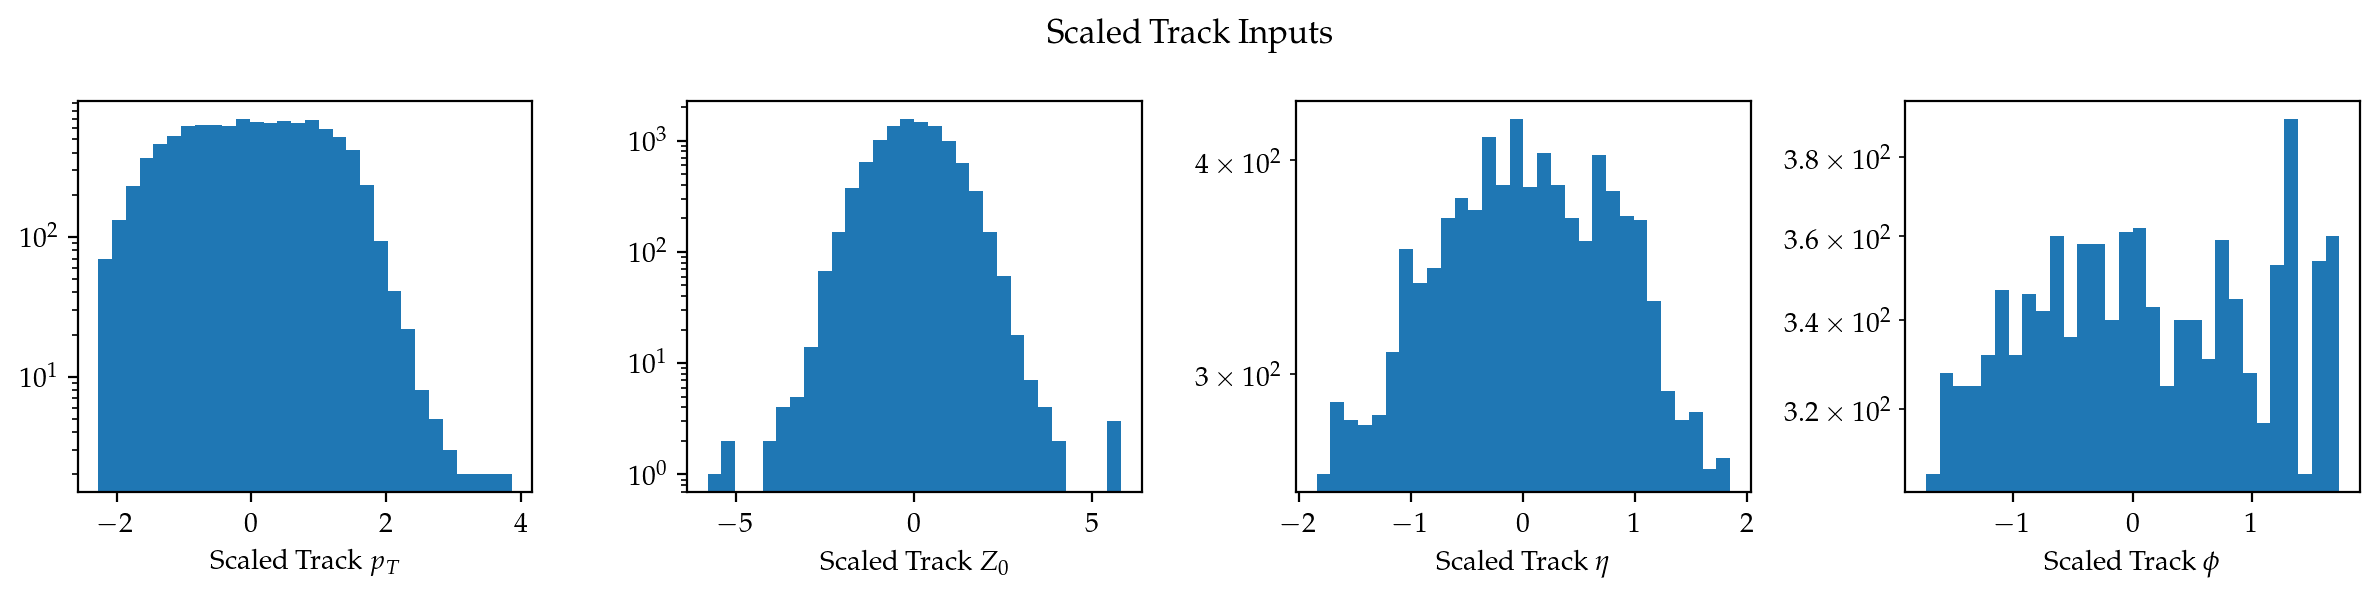

In [ ]:
### Plot preprocessed track inputs 
track_pt = (np.log10(np.concatenate(event_data['trackPt'])) - scales['track_pt_mean'])/scales['track_pt_std']
track_z0 = (np.concatenate(event_data['trackZ0']) - scales['track_z0_mean'])/scales['track_z0_std']
track_eta = (np.concatenate(event_data['trackEta']) - scales['track_eta_mean'])/scales['track_eta_std']
track_phi = (np.concatenate(event_data['trackPhi']) - scales['track_phi_mean'])/scales['track_phi_std']

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,3), dpi=200, tight_layout=True)
fig.suptitle("Scaled Track Inputs")

ax[0].hist(track_pt, bins=30)
ax[0].set_yscale('log')
ax[0].set_xlabel(r'Scaled Track $p_T$')

ax[1].hist(track_z0, bins=30)
ax[1].set_yscale('log')
ax[1].set_xlabel(r'Scaled Track $Z_0$')

ax[2].hist(track_eta, bins=30)
ax[2].set_yscale('log')
ax[2].set_xlabel(r'Scaled Track $\eta$')

ax[3].hist(track_phi, bins=30)
ax[3].set_yscale('log')
ax[3].set_xlabel(r'Scaled Track $\phi$');
plt.savefig("scaled_track_inputs.png");

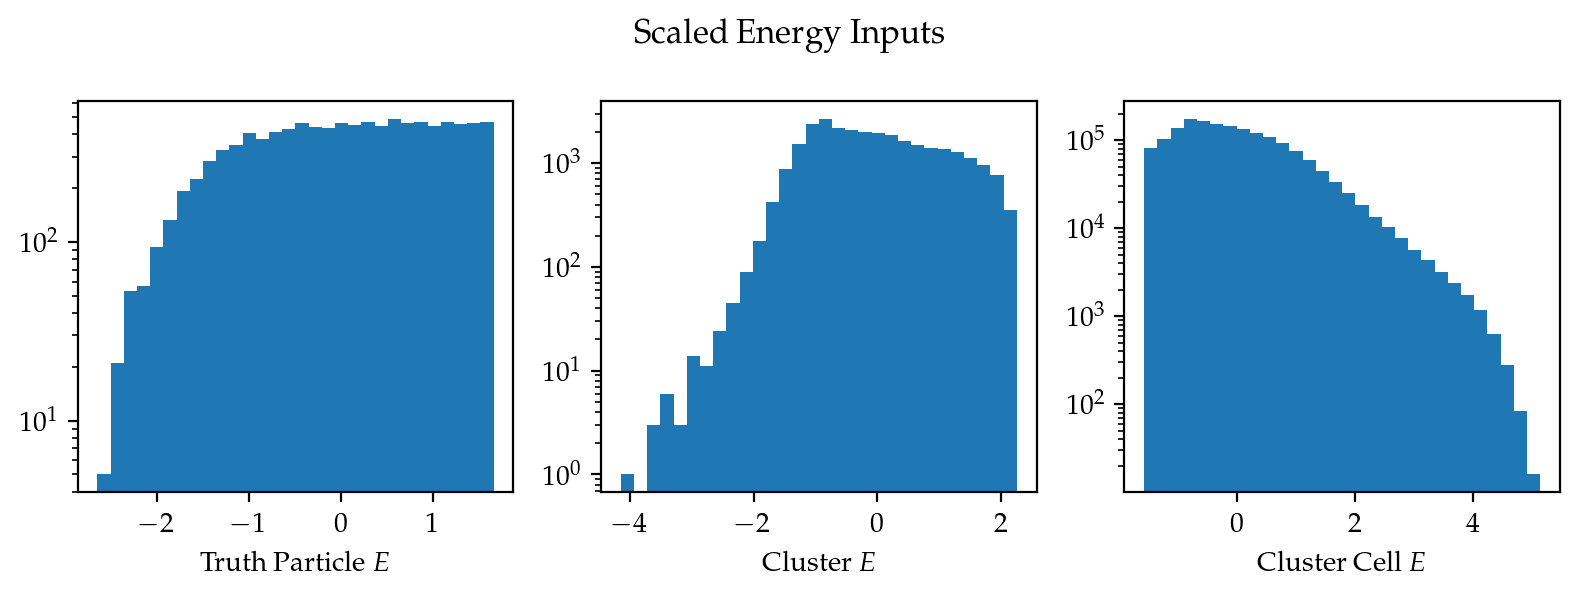

In [ ]:
### Plot preprocessed energy inputs 

all_nodes = []

n_events = len(event_data['index'])
for event_ind in range(n_events):
    for cluster_ind in range(event_data['nCluster'][event_ind]):
        nodes = event_data['cluster_cell_E'][event_ind][cluster_ind]
#         cell_IDs = event_data['cluster_cell_ID'][event_ind][cluster_ind]
#         cell_IDmap = self.sorter[np.searchsorted(self.cellGeo_ID, cell_IDs, sorter=self.sorter)]
#         nodes = np.append(nodes, cell_geo_data['cell_geo_sampling'][0][cell_IDmap])
        nodes = np.reshape(nodes, (1, -1)).T
        all_nodes.append(nodes)

truth_particle_e = (np.log10(np.concatenate(event_data['truthPartE'])) - scales['truth_part_e_mean'])/scales['truth_part_e_std']
cluster_cell_e = (np.log10(np.concatenate(all_nodes)) - scales['cluster_cell_e_mean'])/scales['cluster_cell_e_std']
cluster_e = (np.log10(np.concatenate(event_data['cluster_E'])) - scales['cluster_e_mean'])/scales['cluster_e_std']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,3), dpi=200, tight_layout=True)
fig.suptitle("Scaled Energy Inputs")

ax[0].hist(truth_particle_e, bins=30)
ax[0].set_yscale('log')
ax[0].set_xlabel(r'Truth Particle $E$')

ax[1].hist(cluster_e, bins=30)
ax[1].set_yscale('log')
ax[1].set_xlabel(r'Cluster $E$')

ax[2].hist(cluster_cell_e, bins=30)
ax[2].set_yscale('log')
ax[2].set_xlabel(r'Cluster Cell $E$');
plt.savefig("scaled_energy_inputs.png");

In [ ]:
#export

class GraphDataGenerator:
    """
    DataGenerator class for extracting and formating data from list of root files
    This data generator uses the cell_geo file to create the input graph structure
    """
    def __init__(self,
                 pi0_file_list: list,
                 pion_file_list: list,
                 cellGeo_file: str,
                 batch_size: int,
                 shuffle: bool = True,
                 num_procs = 32,
                 preprocess = False,
                 output_dir = None):
        """Initialization"""

        self.preprocess = preprocess
        self.output_dir = output_dir

        if self.preprocess and self.output_dir is not None:
            self.pi0_file_list = pi0_file_list
            self.pion_file_list = pion_file_list
#             assert len(pi0_file_list) == len(pion_file_list)
            self.num_files = len(self.pion_file_list)
        else:
            self.file_list = pion_file_list
            self.num_files = len(self.file_list)
        
        self.cellGeo_file = cellGeo_file
        
        self.cellGeo_data = ur.open(self.cellGeo_file)['CellGeo']
        self.geoFeatureNames = self.cellGeo_data.keys()[1:9]
        self.nodeFeatureNames = ['cluster_cell_E']
#         self.nodeFeatureNames = ['cluster_cell_E', *self.geoFeatureNames[:-2]]
        self.edgeFeatureNames = []
#         self.edgeFeatureNames = self.cellGeo_data.keys()[9:]
        self.num_nodeFeatures = len(self.nodeFeatureNames)
        self.num_edgeFeatures = len(self.edgeFeatureNames)
        self.cellGeo_data = self.cellGeo_data.arrays(library='np')
        self.cellGeo_ID = self.cellGeo_data['cell_geo_ID'][0]
        self.sorter = np.argsort(self.cellGeo_ID)
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        if self.shuffle: np.random.shuffle(self.file_list)
        
        self.num_procs = np.min([num_procs, self.num_files])
        self.procs = []

        if self.preprocess and self.output_dir is not None:
            os.makedirs(self.output_dir, exist_ok=True)
            self.preprocess_data()
    
    def get_cluster_calib(self, event_data, event_ind, cluster_ind):
        """ Reading cluster calibration energy """ 
        cluster_calib_E = event_data['cluster_ENG_CALIB_TOT'][event_ind][cluster_ind]

        if cluster_calib_E <= 0:
            return None

        return np.log10(cluster_calib_E)
    
    def get_cluster_eta(self, event_data, event_ind, cluster_ind):
        """ Reading cluster eta """ 
        cluster_eta = event_data['cluster_Eta'][event_ind][cluster_ind]
        return cluster_eta
    
    def get_nodes(self, event_data, event_ind, cluster_ind):
        """ Reading Node features """ 

        cell_IDs = event_data['cluster_cell_ID'][event_ind][cluster_ind]
        cell_IDmap = self.sorter[np.searchsorted(self.cellGeo_ID, cell_IDs, sorter=self.sorter)]
        
        global_node = np.log10(event_data['cluster_E'][event_ind][cluster_ind])
        
        nodes = [0]
#         nodes = np.log10(event_data['cluster_cell_E'][event_ind][cluster_ind])
#         nodes = np.append(nodes, self.cellGeo_data['cell_geo_sampling'][0][cell_IDmap])
#         for f in self.nodeFeatureNames[2:4]:
#             nodes = np.append(nodes, self.cellGeo_data[f][0][cell_IDmap])
#         nodes = np.append(nodes, self.cellGeo_data['cell_geo_rPerp'][0][cell_IDmap])
#         for f in self.nodeFeatureNames[5:]:
#             nodes = np.append(nodes, self.cellGeo_data[f][0][cell_IDmap])

        nodes = np.reshape(nodes, (len(self.nodeFeatureNames), -1)).T
        nodes_scaled = (np.concatenate(nodes) - scales['cluster_cell_e_mean'])/scales['cluster_cell_e_std']
        nodes_scaled = np.reshape(nodes, (len(self.nodeFeatureNames), -1)).T
#         nodes_scaled = np.zeros(2)
#         nodes_scaled = (nodes - node_means)/node_stds
        cluster_num_nodes = len(nodes_scaled)

#         # add dummy placeholder nodes for track features (not used in cluster cell nodes)
#         nodes = np.hstack((nodes, np.zeros((cluster_num_nodes, 4))))
        
        return nodes_scaled, np.array([global_node]), cluster_num_nodes, cell_IDmap
    
#     # track section ----------------------------------------------------------------
    
#     def get_track_node(self, event_data, event_index, track_index):
#         """
#         Creates node features for tracks
#         Inputs:
        
#         Returns:
#             1 Dimensional array of node features for a single node
#                 NOTE the cluster get_node function is a 2D array of multiple nodes
#                 This function is used in a for loop so the end result is a 2D array
#         """
#         node_features = np.array(event_data["trackPt"][event_index][track_index])
#         node_features = np.append(node_features, event_data["trackZ0"][event_index][track_index])
#         node_features = np.append(node_features, event_data["trackEta_EMB2"][event_index][track_index])
#         node_features = np.append(node_features, event_data["trackPhi_EMB2"][event_index][track_index])
#         node_features = np.reshape(node_features, (len(node_features))).T
        
#         # add dummy placeholder nodes for track features (not used in track cell nodes)
#         node_features = np.hstack((np.zeros(7), node_features))
    
#         return node_features
    
#     def get_track_edges(self, num_track_nodes, start_index):
#         """
#         Creates the edge senders and recievers and edge features
#         Inputs:
#         (int) num_track_nodes: number of track nodes
#         (int) start_index: the index of senders/recievers to start with. We should start with num_cluster_edges+1 to avoid overlap

#         Returns:
#         (np.array) edge_features:
#         (np.array) senders:
#         (np.array) recievers:
#         """
#         # Full Connected tracks
#         # since we are fully connected, the order of senders and recievers doesn't matter
#         # we just need to count each node - edges will have a placeholder feature
#         connections = list(itertools.permutations(range(start_index, start_index + num_track_nodes),2))
#         for i in range(5):
#             connections.append((i, i))

#         senders = np.array([x[0] for x in connections])
#         recievers = np.array([x[0] for x in connections])
#         edge_features = np.zeros((len(connections), 10))

#         return senders, recievers, edge_features
    
#     # end track section ----------------------------------------------------------------
    
    def get_edges(self, cluster_num_nodes, cell_IDmap):
        """ 
        Reading edge features 
        Returns senders, receivers, and edges    
        """ 
        
        edge_inds = np.zeros((cluster_num_nodes, self.num_edgeFeatures))
        for i, f in enumerate(self.edgeFeatureNames):
            edge_inds[:, i] = self.cellGeo_data[f][0][cell_IDmap]
        edge_inds[np.logical_not(np.isin(edge_inds, cell_IDmap))] = np.nan
        
        senders, edge_on_inds = np.isin(edge_inds, cell_IDmap).nonzero()
        cluster_num_edges = len(senders)
        edges = np.zeros((cluster_num_edges, self.num_edgeFeatures))
        edges[np.arange(cluster_num_edges), edge_on_inds] = 1
        
        cell_IDmap_sorter = np.argsort(cell_IDmap)
        rank = np.searchsorted(cell_IDmap, edge_inds , sorter=cell_IDmap_sorter)
        receivers = cell_IDmap_sorter[rank[rank!=cluster_num_nodes]]
        
        return senders, receivers, edges

    def preprocessor(self, worker_id):
        """
        Prerocessing root file data for faster data 
        generation during multiple training epochs
        """
        file_num = worker_id
        while file_num < self.num_files:
            print(f"Processing file number {file_num}")
            
            ### Pions
            file = self.pion_file_list[file_num]
            event_data = np.load(file, allow_pickle=True).item()
            num_events = len(event_data[[key for key in event_data.keys()][0]])

            preprocessed_data = []

#             for event_ind in range(3):
            for event_ind in range(num_events):
                num_clusters = event_data['nCluster'][event_ind]
                truth_particle_E = np.log10(event_data['truthPartE'][event_ind][0])
                truth_particle_E_scaled = (truth_particle_E - scales['truth_part_e_mean'])/scales['truth_part_e_std']
                truthPartPt = event_data['truthPartPt'][event_ind][0]
                
                for i in range(num_clusters):
                    if event_data['dR_pass'][event_ind][i] == False:
                        continue
                    cluster_calib_E = self.get_cluster_calib(event_data, event_ind, i)
                    cluster_EM_prob = event_data['cluster_EM_PROBABILITY'][event_ind][i]
                    cluster_E = np.log10(event_data['cluster_E'][event_ind][i])
                    cluster_E_scaled = (cluster_E - scales['cluster_e_mean'])/scales['cluster_e_std']
                    cluster_HAD_WEIGHT = event_data['cluster_HAD_WEIGHT'][event_ind][i]
                    
                    if cluster_calib_E is None:
                        continue
                        
                    cluster_eta = self.get_cluster_eta(event_data, event_ind, i)
                        
                    nodes, global_node, cluster_num_nodes, cell_IDmap = self.get_nodes(event_data, event_ind, i)
                    senders, receivers, edges = self.get_edges(cluster_num_nodes, cell_IDmap)
                    
#                 # track section ----------------------------------------------------------------
#                     track_nodes = np.empty((0, 11))
                    num_tracks = event_data['nTrack'][event_ind]
                    for track_index in range(num_tracks):
#                         np.append(track_nodes, self.get_track_node(event_data, event_ind, track_index).reshape(1, -1), axis=0)
                        track_pt = np.log10(event_data["trackPt"][event_ind][track_index])
                        track_z0 = event_data["trackZ0"][event_ind][track_index]
                        track_eta = event_data["trackEta"][event_ind][track_index]
                        track_phi = event_data["trackPhi"][event_ind][track_index]
                
                    track_pt_scaled = (track_pt - scales['track_pt_mean'])/scales['track_pt_std']
                    track_z0_scaled = (track_z0 - scales['track_z0_mean'])/scales['track_z0_std']
                    track_eta_scaled = (track_eta - scales['track_eta_mean'])/scales['track_eta_std']
                    track_phi_scaled = (track_phi - scales['track_phi_mean'])/scales['track_phi_std']
#                     track_senders, track_receivers, track_edge_features = self.get_track_edges(len(track_nodes), cluster_num_nodes)
                    
#                     # append on the track nodes and edges to the cluster ones
#                     nodes = np.append(nodes, np.array(track_nodes), axis=0)
#                     edges = np.append(edges, track_edge_features, axis=0)
#                     senders = np.append(senders, track_senders, axis=0)
#                     receivers = np.append(receivers, track_receivers, axis=0)
                    
#                     # end track section ----------------------------------------------------------------
                
                    globals_list = np.array([
                                             cluster_E_scaled.astype(np.float32), 
                                             track_pt_scaled.astype(np.float32), 
                                             track_z0_scaled.astype(np.float32),
                                             track_eta_scaled.astype(np.float32),
                                             track_phi_scaled.astype(np.float32),
                                             ])
                        
                    graph = {
                            'nodes': nodes.astype(np.float32), 
#                              'globals': global_node.astype(np.float32),
                            'globals': globals_list,                             
                            'senders': senders.astype(np.int32), 
                            'receivers': receivers.astype(np.int32),
                            'edges': edges.astype(np.float32), 
                            'cluster_calib_E': cluster_calib_E.astype(np.float32), 
                            'cluster_eta': cluster_eta.astype(np.float32), 'cluster_EM_prob': cluster_EM_prob.astype(np.float32),
                            'cluster_E': cluster_E.astype(np.float32), 'cluster_HAD_WEIGHT': cluster_HAD_WEIGHT.astype(np.float32), 
                            'truthPartPt': truthPartPt.astype(np.float32), 'truthPartE': truth_particle_E.astype(np.float32), 
                             'track_pt': track_pt.astype(np.float32), 
                             'track_eta': track_eta.astype(np.float32)}
                    target = np.reshape([truth_particle_E_scaled.astype(np.float32), 1], [1,2])
                    preprocessed_data.append((graph, target))

#             ### Pi0
#             file = self.pi0_file_list[file_num]
#             event_data = np.load(file, allow_pickle=True).item()
#             num_events = len(event_data[[key for key in event_data.keys()][0]])

#             for event_ind in range(num_events):
#                 num_clusters = event_data['nCluster'][event_ind]
#                 truth_particle_E = np.log10(event_data['truthPartE'][event_ind][0]) # first one is the pion! 
#                 truthPartPt = event_data['truthPartPt'][event_ind][0]
                
#                 for i in range(num_clusters):
#                     cluster_calib_E = self.get_cluster_calib(event_data, event_ind, i)
#                     cluster_EM_prob = event_data['cluster_EM_PROBABILITY'][event_ind][i]
#                     cluster_E = np.log10(event_data['cluster_E'][event_ind][i])
#                     cluster_HAD_WEIGHT = event_data['cluster_HAD_WEIGHT'][event_ind][i]

#                     if event_data['dR_pass'][event_ind][i] == False:
#                         continue
                        
#                     if cluster_calib_E is None:
#                         continue
                        
#                     cluster_eta = self.get_cluster_eta(event_data, event_ind, i)
                        
#                     nodes, global_node, cluster_num_nodes, cell_IDmap = self.get_nodes(event_data, event_ind, i)
#                     senders, receivers, edges = self.get_edges(cluster_num_nodes, cell_IDmap)         
                    
#                     # track section ----------------------------------------------------------------
#                     track_nodes = np.empty((0, 11))
#                     num_tracks = event_data['nTrack'][event_ind]
#                     for track_index in range(num_tracks):
#                         np.append(track_nodes, self.get_track_node(event_data, event_ind, track_index).reshape(1, -1), axis=0)
#                         track_pt = np.array([np.log10(event_data["trackPt"][event_ind][track_index])])
                        
#                     track_senders, track_receivers, track_edge_features = self.get_track_edges(len(track_nodes), cluster_num_nodes)
                    
#                     nodes = np.append(nodes, np.array(track_nodes), axis=0)
#                     edges = np.append(edges, track_edge_features, axis=0)
#                     senders = np.append(senders, track_senders, axis=0)
#                     receivers = np.append(receivers, track_receivers, axis=0)
                    
#                     # end track section ----------------------------------------------------------------
                                        
#                     graph = {'nodes': nodes.astype(np.float32), 
# #                              'globals': global_node.astype(np.float32),
#                              'globals': track_pt.astype(np.float32),                             
#                         'senders': senders.astype(np.int32), 'receivers': receivers.astype(np.int32),
#                         'edges': edges.astype(np.float32), 'cluster_calib_E': cluster_calib_E.astype(np.float32), 
#                         'cluster_eta': cluster_eta.astype(np.float32), 'cluster_EM_prob': cluster_EM_prob.astype(np.float32),
#                         'cluster_E': cluster_E.astype(np.float32), 'cluster_HAD_WEIGHT': cluster_HAD_WEIGHT.astype(np.float32),
#                         'truthPartPt': truthPartPt.astype(np.float32), 'track_pt': track_pt.astype(np.float32)}
#                     target = np.reshape([truth_particle_E.astype(np.float32), 0], [1,2])
    
#                     preprocessed_data.append((graph, target))

            random.shuffle(preprocessed_data)

            pickle.dump(preprocessed_data, open(self.output_dir + f'data_{file_num:03d}.p', 'wb'), compression='gzip')
            
            print(f"Finished processing {file_num} files")
            file_num += self.num_procs

    def preprocess_data(self):
        print('\nPreprocessing and saving data to {}'.format(self.output_dir))
        for i in range(self.num_procs):
            p = Process(target=self.preprocessor, args=(i,), daemon=True)
            p.start()
            self.procs.append(p)
        
        for p in self.procs:
            p.join()

        self.file_list = [self.output_dir + f'data_{i:03d}.p' for i in range(self.num_files)]

    def preprocessed_worker(self, worker_id, batch_queue):
        batch_graphs = []
        batch_targets = []
        
        file_num = worker_id
        while file_num < self.num_files:
            file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')

            for i in range(len(file_data)):
                batch_graphs.append(file_data[i][0])
                batch_targets.append(file_data[i][1])
                    
                if len(batch_graphs) == self.batch_size:
                    batch_targets = np.reshape(np.array(batch_targets), [-1,2]).astype(np.float32)
                    
                    batch_queue.put((batch_graphs, batch_targets))
                    
                    batch_graphs = []
                    batch_targets = []

            file_num += self.num_procs
                    
        if len(batch_graphs) > 0:
            batch_targets = np.reshape(np.array(batch_targets), [-1,2]).astype(np.float32)
            batch_queue.put((batch_graphs, batch_targets))

    def worker(self, worker_id, batch_queue):
        if self.preprocess:
            self.preprocessed_worker(worker_id, batch_queue)
        else:
            raise Exception('Preprocessing is required for combined classification/regression models.')
        
    def check_procs(self):
        for p in self.procs:
            if p.is_alive(): return True
        
        return False

    def kill_procs(self):
        for p in self.procs:
            p.kill()

        self.procs = []
    
    def generator(self):
        """
        Generator that returns processed batches during training
        """
        batch_queue = Queue(2 * self.num_procs)
            
        for i in range(self.num_procs):
            p = Process(target=self.worker, args=(i, batch_queue), daemon=True)
            p.start()
            self.procs.append(p)
        
        while self.check_procs() or not batch_queue.empty():
            try:
                batch = batch_queue.get(True, 0.0001)
            except:
                continue
            
            yield batch
        
        for p in self.procs:
            p.join()

Test the data generation step...

In [ ]:
data_dir = '/clusterfs/ml4hep/mpettee/ml4pions/data/onetrack_multicluster/'
pi0_files = []#np.sort(glob.glob(data_dir+'pi0_files/*.npy'))[:1]
pion_files = np.sort(glob.glob(data_dir+'pion_files/*.npy'))[:1]

In [ ]:
data_gen = GraphDataGenerator(pion_file_list=pion_files, 
                              pi0_file_list=pi0_files,
                              cellGeo_file='/clusterfs/ml4hep/mpettee/ml4pions/data/cell_geo.root',
                              batch_size=32,
                              shuffle=False,
                              num_procs=32,
                              preprocess=True,
                              output_dir=data_dir)


Preprocessing and saving data to /clusterfs/ml4hep/mpettee/ml4pions/data/onetrack_multicluster/
Processing file number 0
Finished processing 0 files


In [ ]:
# Cell
import numpy as np
import tensorflow as tf
from graph_nets.graphs import GraphsTuple

# Cell
def convert_to_tuple(graphs):
    nodes = []
    edges = []
    global_nodes = []
    senders = []
    receivers = []
    n_node = []
    n_edge = []
    offset = 0
    cluster_energies = []
    cluster_etas = []
    cluster_EM_probs = []
    cluster_calib_Es = []
    cluster_had_weights = []
    truth_particle_es = []
    truth_particle_pts = []
    track_pts = []
    track_etas = []

    for graph in graphs:
        nodes.append(graph['nodes'])
        edges.append(graph['edges'])
        global_nodes.append([graph['globals']])
        senders.append(graph['senders'])
        receivers.append(graph['receivers'])
        senders.append(graph['senders'] + offset)
        receivers.append(graph['receivers'] + offset)
        n_node.append(graph['nodes'].shape[:1])
        n_edge.append(graph['edges'].shape[:1])
        cluster_energies.append(graph['cluster_E'])
        cluster_etas.append(graph['cluster_eta'])
        cluster_EM_probs.append(graph['cluster_EM_prob'])
        cluster_calib_Es.append(graph['cluster_calib_E'])
        cluster_had_weights.append(graph['cluster_HAD_WEIGHT'])
        truth_particle_es.append(graph['truthPartE'])
        truth_particle_pts.append(graph['truthPartPt'])
        track_pts.append(graph['track_pt'])
        track_etas.append(graph['track_eta'])

        offset += len(graph['nodes'])

    nodes = tf.convert_to_tensor(np.concatenate(nodes))
    edges = tf.convert_to_tensor(np.concatenate(edges))
    global_nodes = tf.convert_to_tensor(np.concatenate(global_nodes))
    senders = tf.convert_to_tensor(np.concatenate(senders))
    receivers = tf.convert_to_tensor(np.concatenate(receivers))
    n_node = tf.convert_to_tensor(np.concatenate(n_node))
    n_edge = tf.convert_to_tensor(np.concatenate(n_edge))

    graph = GraphsTuple(
            nodes=nodes,
            edges=edges,
            globals=global_nodes,
            senders=senders,
            receivers=receivers,
            n_node=n_node,
            n_edge=n_edge
        )

    return graph, cluster_energies, cluster_etas, cluster_EM_probs, cluster_calib_Es, cluster_had_weights, truth_particle_es, truth_particle_pts, track_pts, track_etas

In [ ]:
# Get batch of data
def get_batch(data_iter):
    for graphs, targets in data_iter:
        targets = tf.convert_to_tensor(targets)
        graphs, energies, etas, em_probs, cluster_calib_es, cluster_had_weights, truth_particle_es, truth_particle_pts, track_pts, track_etas = convert_to_tuple(graphs)
        yield graphs, targets, energies, etas, em_probs, cluster_calib_es, cluster_had_weights, truth_particle_es, truth_particle_pts, track_pts, track_etas

samp_graph, samp_target, _, _, _, _, _, _, _, _, _ = next(get_batch(data_gen.generator()))

2022-05-03 12:47:43.452933: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-03 12:47:45.378478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 527 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-05-03 12:47:45.379297: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43229 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6
2022-05-03 12:47:45.379957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU

In [ ]:
samp_graph

GraphsTuple(nodes=<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>, edges=<tf.Tensor: shape=(0, 0), dtype=float32, numpy=array([], shape=(0, 0), dtype=float32)>, receivers=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>, senders=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>, globals=<tf.Tensor: shape=(32, 5), dtype=float32, numpy=
array([[ 1.7043495 ,  1.7386558 ,  0.11561624, -0.6586571 ,  1.4693177 ],
       [ 0.48720655, -0.4030332 ,  2.9525492 ,  1.2354236 , -1.6319866 ],
       [ 0.83086544, -0.34609333,  0.4947313 ,